In [ ]:
# 중심축 기반 부피 계산
import trimesh
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares

# 상수 정의


THICKNESS = 0.0003 ##단면의 두께
MIN_POINTS_PER_SLICE = 10 ##원 검출 시 최소 포인트 수
MAX_CONSECUTIVE_FAILURES = 10 ##원 검출 시 최대 연속 실패 횟수
MIN_RADIUS, MAX_RADIUS = 0.02, 0.1 ##원 검출 시 최소 및 최대 반지름
MIN_POINTS_PER_METER = 50.0 ##중심축 기반 원검출시 최소 포인트 수


# 바닥 검출 파라미터
INNER_RADIUS_RATIO = 0.6      # 원 반지름의 60% 이내를 내부로 간주
MIN_INNER_DENSITY = 400000.0      # 최소 밀도 (points/m²)
MIN_INNER_RATIO = 0.08        # 최소 비율 (전체의 8%)
BOTTOM_SEARCH_RATIO = 0.2     # 하위 20%만 바닥 검출

# 중심축 선정을 위한 지표 가중치
WEIGHT_PPM = 0.34
WEIGHT_ANGLE_COVERAGE = 0.33
WEIGHT_GRID_COVERAGE = 0.33
WEIGHT_INLIER_RATIO = 0

# 그리드 기반 커버리지 계산 파라미터
GRID_SIZE = 40  
INNER_RADIUS_RATIO_FOR_GRID = 0.8  # 원 반지름의 60% 이내

# 각도 커버리지 계산 파라미터
ANGLE_SEGMENTS = 180  

# GLB 로드 및 z축이 중력방향이 되도록 scene을 회전하는 함수
def load_and_align_scene(filepath):
    scene = trimesh.load(filepath)
    A = np.array(scene.metadata.get('hf_alignment', np.eye(4))).reshape(4, 4)
    gravity = (A[:3, :3] @ np.array([[1,0,0],[0,-1,0],[0,0,-1]]) @ np.array([0,1,0]))
    gravity = gravity / np.linalg.norm(gravity)
    
    R = Rotation.align_vectors([[0, 0, 1]], [gravity])[0]
    T = np.eye(4)
    T[:3, :3] = R.as_matrix()
    for geom in scene.geometry.values():
        geom.apply_transform(T)
    
    for geometry in scene.geometry.values():
        if isinstance(geometry, trimesh.PointCloud):
            return geometry.vertices
    return None


# 원 검출 함수들

def calculate_ppm(inlier_points, radius):
    """둘레당 인라이너 포인트 수 계산 (Points Per Meter)"""
    if radius <= 0:
        return 0.0
    circumference = 2 * np.pi * radius
    n_inliers = len(inlier_points)
    ppm = n_inliers / circumference if circumference > 0 else 0
    return ppm

def calculate_angle_coverage(inlier_points, center):
    """인라이너가 원 둘레를 커버하는 정도 계산 (0.0 ~ 1.0)"""
    if len(inlier_points) == 0:
        return 0.0
    
    # 각 포인트의 각도 계산
    relative_points = inlier_points - center
    angles = np.arctan2(relative_points[:, 1], relative_points[:, 0])
    
    # 각도를 0~2π 범위로 정규화
    angles = (angles + 2 * np.pi) % (2 * np.pi)
    
    # 각도 구간으로 나누기
    segment_size = 2 * np.pi / ANGLE_SEGMENTS
    segment_indices = (angles / segment_size).astype(int)
    segment_indices = np.clip(segment_indices, 0, ANGLE_SEGMENTS - 1)
    
    # 커버된 구간 수 계산
    covered_segments = len(np.unique(segment_indices))
    coverage = covered_segments / ANGLE_SEGMENTS
    
    return coverage

def calculate_grid_coverage(points_2d, center, radius, inner_radius_ratio=INNER_RADIUS_RATIO_FOR_GRID, grid_size=GRID_SIZE):
    """그리드 기반 면적 커버리지 계산 (0.0 ~ 1.0, 낮을수록 좋음)"""
    inner_radius = radius * inner_radius_ratio
    
    # 내부 포인트 필터링
    distances = np.linalg.norm(points_2d - center, axis=1)
    inner_points = points_2d[distances < inner_radius]
    
    if len(inner_points) == 0:
        return 0.0  # 완전히 비어있음 (최고)
    
    # 그리드 범위 계산
    x_min, x_max = center[0] - inner_radius, center[0] + inner_radius
    y_min, y_max = center[1] - inner_radius, center[1] + inner_radius
    
    # 그리드 셀 크기
    cell_size_x = (x_max - x_min) / grid_size
    cell_size_y = (y_max - y_min) / grid_size
    
    if cell_size_x <= 0 or cell_size_y <= 0:
        return 0.0
    
    # 각 포인트가 속한 그리드 셀 인덱스 계산
    grid_x = ((inner_points[:, 0] - x_min) / cell_size_x).astype(int)
    grid_y = ((inner_points[:, 1] - y_min) / cell_size_y).astype(int)
    
    # 그리드 범위 내로 클리핑
    grid_x = np.clip(grid_x, 0, grid_size - 1)
    grid_y = np.clip(grid_y, 0, grid_size - 1)
    
    # 포인트가 있는 셀 찾기
    occupied_cells = set(zip(grid_x, grid_y))
    coverage = len(occupied_cells) / (grid_size * grid_size)
    
    return coverage

# 인라이너 포인트들을 받아서 원의 중심과 반지름을 정확하게 추정하는 함수
def refine_circle_ls(inlier_points):
    if len(inlier_points) < 3:
        return None
    center_init = inlier_points.mean(axis=0)
    radius_init = np.mean(np.linalg.norm(inlier_points - center_init, axis=1))
    
    def residuals(params):
        cx, cy, r = params
        return np.linalg.norm(inlier_points - [cx, cy], axis=1) - r
    
    try:
        result = least_squares(residuals, [center_init[0], center_init[1], radius_init],
                              bounds=([-0.5, -0.5, 0.001], [0.5, 0.5, 0.2]))
        cx, cy, r = result.x
        if 0.01 < r < 0.15:
            return {'center': np.array([cx, cy]), 'radius': r}
    except:
        pass
    return None

# 랜덤 샘플링을 통해 원을 추정하는 함수.한 단면에서 최적의 원을 찾을 때는 단순히 가장 원다운 원(인라이너 비율)을 찾음.
# 여러 단면에서 나온 원들 중에에 중심축을 추정하기 위한 단면을 고를때는 원점과 원중심까지의 거리를 고려해서 상위 5개의 단면의 원들의 중앙값 사용용
def fit_circle_ransac(points_2d, n_iter=200, threshold=0.005, min_inliers=10):
    if len(points_2d) < 3:
        return None
    
    # PPM 제외한 가중치 정규화 (합이 1이 되도록)
    sum_without_ppm = WEIGHT_ANGLE_COVERAGE + WEIGHT_GRID_COVERAGE + WEIGHT_INLIER_RATIO
    weight_angle_norm = WEIGHT_ANGLE_COVERAGE / sum_without_ppm
    weight_grid_norm = WEIGHT_GRID_COVERAGE / sum_without_ppm
    weight_inlier_norm = WEIGHT_INLIER_RATIO / sum_without_ppm
    
    best_circle, best_score = None, -1.0
    for _ in range(n_iter):
        p1, p2, p3 = points_2d[np.random.choice(len(points_2d), 3, replace=False)]
        try:
            A = np.array([[2*(p2[0]-p1[0]), 2*(p2[1]-p1[1])],
                         [2*(p3[0]-p1[0]), 2*(p3[1]-p1[1])]])
            b = np.array([p2[0]**2 - p1[0]**2 + p2[1]**2 - p1[1]**2,
                         p3[0]**2 - p1[0]**2 + p3[1]**2 - p1[1]**2])
            center = np.linalg.solve(A, b)
            radius = np.linalg.norm(p1 - center)
            
            if not (0.01 < radius < 0.15):
                continue
            
            distances = np.abs(np.linalg.norm(points_2d - center, axis=1) - radius)
            inliers = distances < threshold
            n_inliers = np.sum(inliers)
            
            if n_inliers < min_inliers:
                continue
            
            # refine
            refined = refine_circle_ls(points_2d[inliers])
            if refined:
                # 인라이너 포인트 추출
                inlier_points = points_2d[inliers]
                inlier_ratio = n_inliers / len(points_2d)
                
                # 지표 계산 (정규화 불필요, 이미 0~1 범위)
                angle_coverage = calculate_angle_coverage(inlier_points, refined['center'])
                grid_coverage = calculate_grid_coverage(points_2d, refined['center'], refined['radius'])
                grid_coverage_inverted = 1.0 - grid_coverage  # 반전 (낮을수록 좋음)
                
                # 곱셈 방식으로 점수 계산 (가중치를 지수로 사용)
                # 0 방지를 위해 작은 값 추가
                score = ((inlier_ratio + 1e-8) ** weight_inlier_norm * 
                        (angle_coverage + 1e-8) ** weight_angle_norm * 
                        (grid_coverage_inverted + 1e-8) ** weight_grid_norm)
                
                if score > best_score:
                    best_score = score
                    # PPM은 나중에 계산 (중심축 선정용)
                    ppm = calculate_ppm(inlier_points, refined['radius'])
                    best_circle = {
                        **refined, 
                        'score': inlier_ratio,  # 기존 호환성
                        'n_inliers': n_inliers,
                        'ppm': ppm,
                        'angle_coverage': angle_coverage,
                        'grid_coverage': grid_coverage
                    }
        except np.linalg.LinAlgError:
            continue
    return best_circle

def detect_circle_at_axis(slice_2d, center_axis, n_iter=100, threshold=0.0003, prefer_inner=True):
    """중심축 기반으로 원 검출 함수. 원의 둘레당 포인트 수를 기반으로 원을 판별 및 면적 계산."""
    if len(slice_2d) < MIN_POINTS_PER_SLICE:
        return None
    
    distances = np.linalg.norm(slice_2d - center_axis, axis=1)
    best_radius, best_score = None, -1.0
    
    for _ in range(n_iter):
        r_candidate = distances[np.random.randint(len(slice_2d))]
        if not (MIN_RADIUS <= r_candidate <= MAX_RADIUS):
            continue
        
        inlier_count = np.sum(np.abs(distances - r_candidate) < threshold)
        circumference = 2 * np.pi * r_candidate
        ppm = inlier_count / circumference if circumference > 0 else 0
        
        # 내벽 선호: 작은 반지름에 가중치 부여
        if prefer_inner:
            # 반지름이 작을수록 높은 가중치 (MAX_RADIUS 기준으로 정규화)
            radius_weight = 1.0 + (MAX_RADIUS - r_candidate) / MAX_RADIUS
            score = ppm * radius_weight
        else:
            score = ppm
        
        if score > best_score:
            best_score, best_radius = score, r_candidate
    
    # 최종 검증: 원래 ppm 기준으로도 최소 임계값 확인
    if best_radius:
        final_inlier_count = np.sum(np.abs(distances - best_radius) < threshold)
        final_circumference = 2 * np.pi * best_radius
        final_ppm = final_inlier_count / final_circumference if final_circumference > 0 else 0
        
        if final_ppm >= MIN_POINTS_PER_METER:
            return best_radius
    return None

def check_has_bottom(slice_2d, center_axis, radius, threshold=0.0003):
    """바닥이 있는지 확인하는 함수"""
    if len(slice_2d) < MIN_POINTS_PER_SLICE:
        return False
    
    distances = np.linalg.norm(slice_2d - center_axis, axis=1)
    
    # 내부 반지름 (원 반지름의 60% 이내)
    inner_radius = radius * INNER_RADIUS_RATIO
    inner_mask = distances < inner_radius
    inner_count = np.sum(inner_mask)
    
    if inner_count == 0:
        return False  # 내부 포인트가 없으면 바닥 없음
    
    # 밀도 확인만 사용
    inner_area = np.pi * inner_radius ** 2
    inner_density = inner_count / inner_area if inner_area > 0 else 0
    
    # 밀도 조건만으로 판정
    has_bottom = inner_density >= MIN_INNER_DENSITY
    
    return has_bottom

# 유틸리티 함수들
def get_slice(points, z, thickness=THICKNESS):
    """높이 z에서 슬라이스 추출"""
    mask = (points[:, 2] >= z - thickness) & (points[:, 2] <= z + thickness)
    return points[mask]

def add_volume_data(volume_data, z, radius):
    """volume_data에 단면 정보 추가"""
    volume_data.append({'z': z, 'radius': radius, 'area': np.pi * radius**2})

def search_heights(points, z_range, center_axis, volume_data, max_failures=MAX_CONSECUTIVE_FAILURES):
    """높이 범위를 탐색하며 원 검출"""
    failures = 0
    for z in z_range:
        slice_points = get_slice(points, z)
        if len(slice_points) < MIN_POINTS_PER_SLICE:
            failures += 1
            if failures >= max_failures:
                break
            continue
        
        radius = detect_circle_at_axis(slice_points[:, :2], center_axis)
        if radius is not None:
            failures = 0
            add_volume_data(volume_data, z, radius)
        else:
            failures += 1
            if failures >= max_failures:
                break



# 메인 로직
points = load_and_align_scene('/data/ephemeral/home/project/output/scene.glb')

# 전처리: 원점 근처 필터링 및 정렬
mask = np.linalg.norm(points[:, :2], axis=1) < 0.5 #원점기준 xy거리 0.2m 이하 필터링
filtered = points[mask]
sorted_idx = np.argsort(filtered[:, 2])
sorted_points, sorted_heights = filtered[sorted_idx], filtered[sorted_idx, 2]

# 1단계: 중심축 계산
z_range = np.linspace(sorted_heights.min(), sorted_heights.max(), 50) #z축 범위 20개 구간으로 나누기.
circle_data = []
origin = np.array([0, 0])

for z in z_range:
    start = np.searchsorted(sorted_heights, z - THICKNESS)
    end = np.searchsorted(sorted_heights, z + THICKNESS)
    if end - start < MIN_POINTS_PER_SLICE:
        continue
    
    slice_2d = sorted_points[start:end, :2]
    # 원 검출 (새로운 지표 포함)
    circle = fit_circle_ransac(slice_2d, n_iter=30, threshold=0.005, min_inliers=10)
    
    if circle and 'ppm' in circle and 'angle_coverage' in circle and 'grid_coverage' in circle:
        circle_data.append({
            'z': z,
            'center': circle['center'],
            'radius': circle['radius'],
            'score': circle['score'],
            'ppm': circle['ppm'],
            'angle_coverage': circle['angle_coverage'],
            'grid_coverage': circle['grid_coverage']
        })

if not circle_data:
    print("컵 원을 찾지 못했습니다.")
else:
    # 정규화를 위한 최대/최소값 계산 (PPM만 정규화 필요)
    all_ppms = [c['ppm'] for c in circle_data]
    ppm_min, ppm_max = min(all_ppms), max(all_ppms)
    
    # 각 원에 대해 점수 계산
    for circle in circle_data:
        # PPM만 정규화 (큰 값이므로)
        ppm_norm = (circle['ppm'] - ppm_min) / (ppm_max - ppm_min + 1e-8)
        
        # 나머지 지표는 정규화 없이 바로 사용 (이미 0~1 범위)
        inlier_ratio = circle['score']  # 이미 0~1
        angle_coverage = circle['angle_coverage']  # 이미 0~1
        grid_coverage_inverted = 1.0 - circle['grid_coverage']  # 반전 (낮을수록 좋음)
        
        # 곱셈 방식으로 점수 계산 (가중치를 지수로 사용)
        # 0 방지를 위해 작은 값 추가
        final_score = ((ppm_norm + 1e-8) ** WEIGHT_PPM * 
                      (inlier_ratio + 1e-8) ** WEIGHT_INLIER_RATIO * 
                      (angle_coverage + 1e-8) ** WEIGHT_ANGLE_COVERAGE * 
                      (grid_coverage_inverted + 1e-8) ** WEIGHT_GRID_COVERAGE)
        
        circle['final_score'] = final_score
    
    # final_score 기준으로 정렬하여 가장 높은 점수의 단면 선택
    circle_data.sort(key=lambda x: x['final_score'], reverse=True)
    best_circle = circle_data[0]  # 점수가 가장 높은 단면
    center_axis = best_circle['center']  # 가장 높은 점수 단면의 중심을 중심축으로 사용
    reference_z = best_circle['z']  # 부피 계산 할때 처음 탐색을 시작할 z값. final score가장 높은 단면
    
    print(f"중심축: ({center_axis[0]:.6f}, {center_axis[1]:.6f}), 기준 높이: {reference_z:.4f}m")
    
    # 2단계: 부피 계산을 위한 원 검출
    volume_data = []
    z_min, z_max = points[:, 2].min(), points[:, 2].max()
    STEP = 0.002  # 2mm 간격
    
    # 기준 높이에서 원 검출 시도
    ref_slice = get_slice(points, reference_z)
    if len(ref_slice) >= MIN_POINTS_PER_SLICE:
        ref_radius = detect_circle_at_axis(ref_slice[:, :2], center_axis)
        if ref_radius:
            add_volume_data(volume_data, reference_z, ref_radius)
    
    # 위쪽 탐색: 기준 높이 + 0.002, + 0.004, ... (z_max까지)
    z_above = np.arange(reference_z + STEP, z_max + STEP, STEP)
    search_heights(points, z_above, center_axis, volume_data)
    
    # 아래쪽 탐색: 기준 높이 - 0.002, - 0.004, ... (z_min까지)
    z_below = np.arange(reference_z - STEP, z_min - STEP, -STEP)
    search_heights(points, z_below, center_axis, volume_data)
    


    # 3단계: 하위 20% 범위에서만 바닥 검출
    if volume_data:
        volume_data.sort(key=lambda x: x['z'])
        
        # 높이 범위 계산
        height_range = volume_data[-1]['z'] - volume_data[0]['z']
        bottom_20_percent_range = height_range * BOTTOM_SEARCH_RATIO
        bottom_20_end_z = volume_data[0]['z'] + bottom_20_percent_range
        
        print(f"\n바닥 검출 범위: {volume_data[0]['z']:.4f}m ~ {bottom_20_end_z:.4f}m (하위 20%)")
        
        # 하위 20% 범위의 데이터만 바닥 검출
        bottom_detected_heights = []
        for data in volume_data:
            z = data['z']
            # 하위 20% 범위에 있는지 확인
            if z <= bottom_20_end_z:
                radius = data['radius']
                slice_points = get_slice(points, z)
                
                if len(slice_points) >= MIN_POINTS_PER_SLICE:
                    has_bottom = check_has_bottom(slice_points[:, :2], center_axis, radius)
                    if has_bottom:
                        bottom_detected_heights.append(z)
        
        # 바닥이 있는 가장 높은 높이 찾기
        if bottom_detected_heights:
            bottom_end_z = max(bottom_detected_heights)
            print(f"바닥 검출: {len(bottom_detected_heights)}개 높이에서 바닥 발견")
            print(f"바닥 끝 높이: {bottom_end_z:.4f}m")
            
            # 바닥이 아닌 부분만 필터링 (바닥 끝 높이보다 위쪽만)
            volume_data_filtered = [data for data in volume_data if data['z'] > bottom_end_z]
            
            print(f"필터링 전: {len(volume_data)}개 단면")
            print(f"필터링 후: {len(volume_data_filtered)}개 단면 (바닥 제외)")
            
            if len(volume_data_filtered) > 1:
                volume_data = volume_data_filtered
            else:
                print("경고: 바닥을 제외하면 단면이 부족합니다. 전체 데이터 사용.")
        else:
            print("하위 20% 범위에서 바닥이 검출되지 않았습니다. 전체 데이터로 부피 계산합니다.")


    # 4단계: 부피 계산
    if volume_data:
        volume_data.sort(key=lambda x: x['z'])
        total_volume = sum((volume_data[i]['area'] + volume_data[i+1]['area']) / 2 * 
                          (volume_data[i+1]['z'] - volume_data[i]['z']) 
                          for i in range(len(volume_data) - 1))
        
        print(f"\n단면 개수: {len(volume_data)}개")
        print(f"높이: {volume_data[0]['z']:.4f}m ~ {volume_data[-1]['z']:.4f}m")
        print(f"부피: {total_volume * 1000:.2f} mL ({total_volume * 1e6:.2f} cm³)")
    else:
        print("원을 찾지 못했습니다.")

중심축: (-0.027476, 0.122919), 기준 높이: 0.1267m

바닥 검출 범위: 0.0447m ~ 0.0615m (하위 20%)
하위 20% 범위에서 바닥이 검출되지 않았습니다. 전체 데이터로 부피 계산합니다.

단면 개수: 35개
높이: 0.0447m ~ 0.1287m
부피: 0.63 mL (632.95 cm³)


In [72]:
#중심축 상위 5개단면 시각화화
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_top_circles(circle_data, sorted_points, sorted_heights, top_n=5, THICKNESS=0.0003):
    """
    중심축 선정 시 점수가 높은 상위 N개 단면을 시각화
    
    Parameters:
    - circle_data: 점수 계산이 완료된 원 데이터 리스트
    - sorted_points: 정렬된 포인트 배열
    - sorted_heights: 정렬된 높이 배열
    - top_n: 시각화할 상위 개수 (기본 5개)
    - THICKNESS: 단면 두께
    """
    # final_score 기준으로 정렬
    sorted_circles = sorted(circle_data, key=lambda x: x['final_score'], reverse=True)
    top_circles = sorted_circles[:top_n]
    
    # 서브플롯 생성
    n_cols = min(3, top_n)
    n_rows = (top_n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    if top_n == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes
    
    for idx, circle in enumerate(top_circles):
        ax = axes[idx]
        z = circle['z']
        center = circle['center']
        radius = circle['radius']
        
        # 해당 높이의 슬라이스 포인트 추출
        start = np.searchsorted(sorted_heights, z - THICKNESS)
        end = np.searchsorted(sorted_heights, z + THICKNESS)
        slice_points = sorted_points[start:end, :2]
        
        # 포인트 플롯
        ax.scatter(slice_points[:, 0], slice_points[:, 1], 
                  s=1, alpha=0.5, c='gray', label='Points')
        
        # 검출된 원 그리기
        circle_patch = patches.Circle(center, radius, 
                                     fill=False, edgecolor='red', 
                                     linewidth=2, label='Detected Circle')
        ax.add_patch(circle_patch)
        
        # 원의 중심 표시
        ax.plot(center[0], center[1], 'ro', markersize=8, label='Center')
        
        # 내부 영역 표시 (그리드 커버리지 계산용)
        inner_radius = radius * INNER_RADIUS_RATIO_FOR_GRID
        inner_circle = patches.Circle(center, inner_radius,
                                      fill=False, edgecolor='blue',
                                      linewidth=1, linestyle='--', 
                                      label='Inner Region (60%)')
        ax.add_patch(inner_circle)
        
        # 지표 정보 텍스트
        info_text = (
            f"Rank: #{idx+1}\n"
            f"Height: {z:.4f}m\n"
            f"Final Score: {circle['final_score']:.3f}\n"
            f"PPM: {circle['ppm']:.1f}\n"
            f"Angle Coverage: {circle['angle_coverage']:.3f}\n"
            f"Grid Coverage: {circle['grid_coverage']:.3f}\n"
            f"Radius: {radius:.4f}m"
        )
        
        ax.text(0.02, 0.98, info_text, 
               transform=ax.transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=9)
        
        # 축 설정
        ax.set_xlim(center[0] - radius * 1.5, center[0] + radius * 1.5)
        ax.set_ylim(center[1] - radius * 1.5, center[1] + radius * 1.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_title(f'Top {idx+1}: z={z:.4f}m, Score={circle["final_score"]:.3f}')
        ax.legend(loc='upper right', fontsize=7)
    
    # 사용하지 않는 서브플롯 숨기기
    for idx in range(len(top_circles), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 상위 5개 원의 통계 정보 출력
    print(f"\n=== 상위 {top_n}개 원 통계 ===")
    print(f"{'Rank':<6} {'Height(m)':<12} {'Final Score':<12} {'PPM':<10} {'Angle Cov':<12} {'Grid Cov':<12} {'Radius(m)':<12}")
    print("-" * 90)
    for idx, circle in enumerate(top_circles):
        print(f"{idx+1:<6} {circle['z']:<12.4f} {circle['final_score']:<12.3f} "
              f"{circle['ppm']:<10.1f} {circle['angle_coverage']:<12.3f} "
              f"{circle['grid_coverage']:<12.3f} {circle['radius']:<12.4f}")

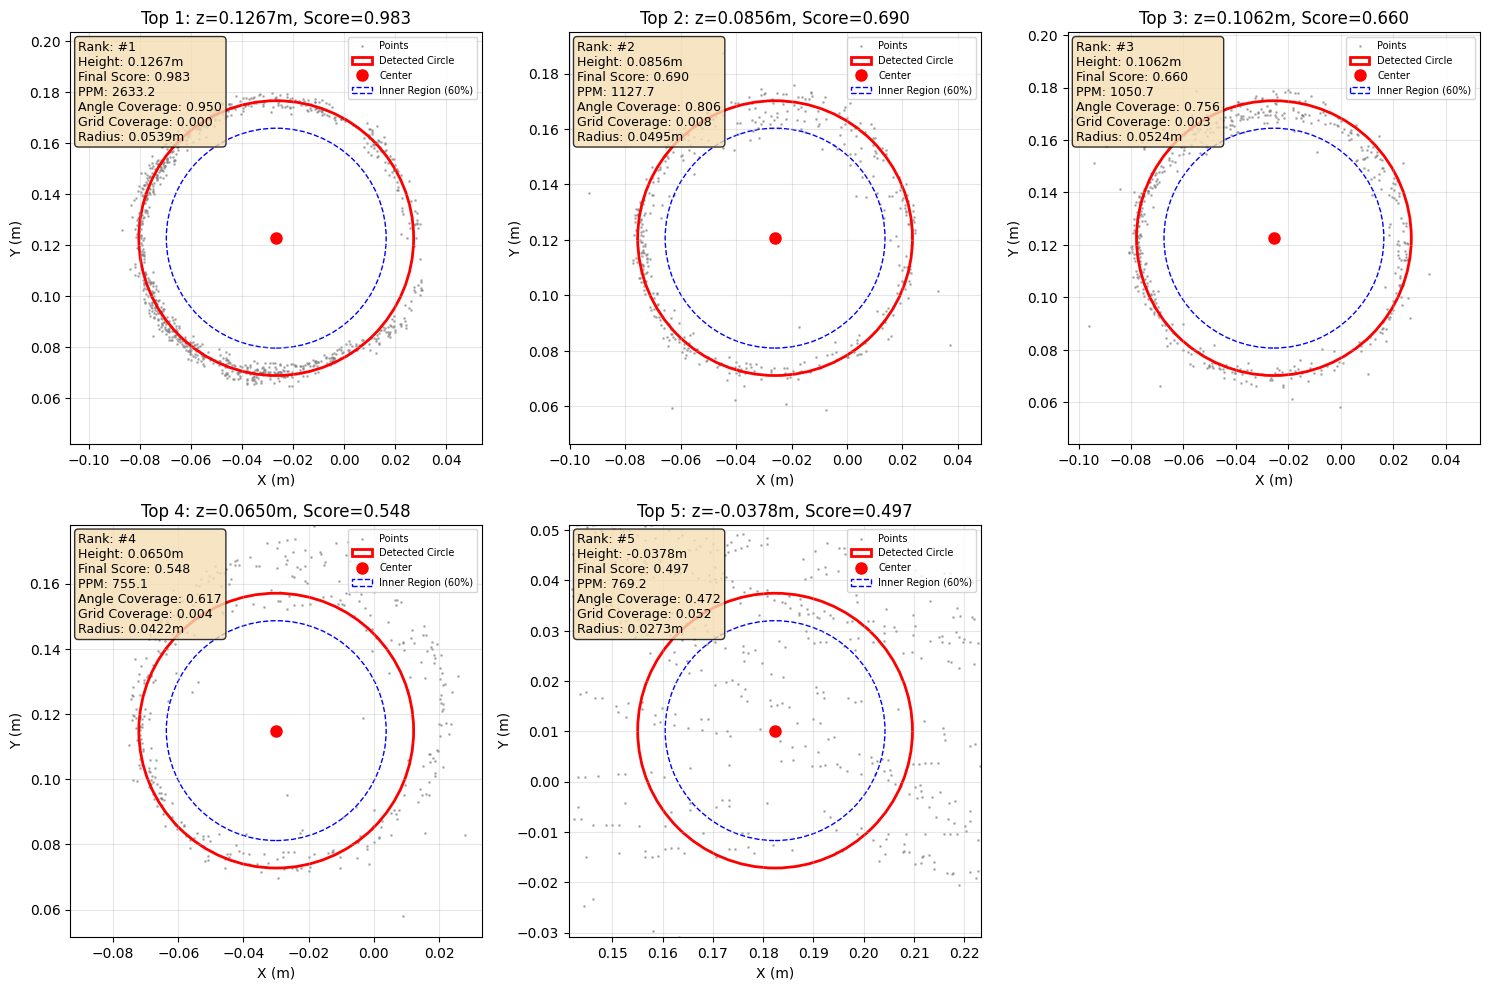


=== 상위 5개 원 통계 ===
Rank   Height(m)    Final Score  PPM        Angle Cov    Grid Cov     Radius(m)   
------------------------------------------------------------------------------------------
1      0.1267       0.983        2633.2     0.950        0.000        0.0539      
2      0.0856       0.690        1127.7     0.806        0.008        0.0495      
3      0.1062       0.660        1050.7     0.756        0.003        0.0524      
4      0.0650       0.548        755.1      0.617        0.004        0.0422      
5      -0.0378      0.497        769.2      0.472        0.052        0.0273      


In [77]:
visualize_top_circles(circle_data, sorted_points, sorted_heights, top_n=5, THICKNESS=THICKNESS)